# Código para o Treinamento das Termografias em YOLOv8 -> Configuração

In [ ]:
!python --version
from google.colab import files
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive')

Python 3.11.13
Mounted at /content/drive


In [ ]:
!pip install -q pycocotools tqdm opencv-python

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import json
import os
from pycocotools import mask
from PIL import Image
import numpy as np
from tqdm import tqdm

dataset_dir = '/content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset'

def coco_segmentation_to_yolo(dataset_dir, split):
    json_path = os.path.join(dataset_dir, split, 'annotations5.json')

    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    images = {img["id"]: img for img in coco_data["images"]}
    categories = {cat["id"]: cat["name"] for cat in coco_data["categories"]}
    ann_by_image = {}

    for ann in coco_data["annotations"]:
        img_id = ann["image_id"]
        if img_id not in ann_by_image:
            ann_by_image[img_id] = []
        ann_by_image[img_id].append(ann)

    for img_id, anns in tqdm(ann_by_image.items(), desc=f"Convertendo {split}"):
        img_info = images[img_id]
        width, height = img_info["width"], img_info["height"]
        image_name = img_info["file_name"]
        label_path = os.path.join(
            dataset_dir, split, os.path.splitext(image_name)[0] + '.txt'
        )

        lines = []

        for ann in anns:
            segm = ann["segmentation"]
            class_id = ann["category_id"] - 1  # começa do 0
            if isinstance(segm, list):  # Polígono
                for s in segm:
                    points = np.array(s).reshape(-1, 2)
                    norm_points = points / [width, height]
                    norm_points = norm_points.flatten()
                    line = f"{class_id} " + " ".join([f"{x:.6f}" for x in norm_points])
                    lines.append(line)

        with open(label_path, 'w') as f:
            f.write("\n".join(lines))

In [ ]:
base_dir = "/content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset"
coco_segmentation_to_yolo(base_dir, "train")
coco_segmentation_to_yolo(base_dir, "val")

Convertendo val: 100%|██████████| 289/289 [00:01<00:00, 200.10it/s]


In [ ]:
yaml_path = os.path.join(base_dir, '..', 'dataset.yaml')
with open(yaml_path, 'w') as f:
    f.write(
        f"path: {os.path.abspath(base_dir)}\n"
        f"train: train\n"
        f"val: val\n"
        f"names:\n  0: modulo_termico\n"
    )
print(f"`dataset.yaml` criado em: {yaml_path}")

`dataset.yaml` criado em: /content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset/../dataset.yaml


# Código para as Termografias YOLOv8 -> Treinar com Ultralytics YOLOv8

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8x-seg.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 137M/137M [00:00<00:00, 303MB/s]


In [ ]:
# Treinar
model.train(
    data='/content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset.yaml',
    epochs=100,
    imgsz=768,
    batch=8,
    device= 0,
    #patience = 10,
    plots = True,
)

Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=768, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset/train.cache... 231 images, 1 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.9±0.4 ms, read: 2.3±2.3 MB/s, size: 8.0 KB)


val: Scanning /content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset/val.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to runs/segment/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.8G     0.4145     0.5096     0.3278     0.9348         66        768: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all         58        160      0.957       0.97       0.99      0.919      0.957       0.97       0.99      0.928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.8G     0.5057     0.5775     0.3902      0.977         49        768: 100%|██████████| 29/29 [00:06<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all         58        160      0.886      0.956      0.968      0.854      0.886      0.956      0.964       0.87



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.8G     0.5258     0.6017      0.399     0.9866         46        768: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all         58        160      0.962          1      0.992      0.917      0.962          1      0.992      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.8G     0.5201     0.6332     0.4362     0.9863         41        768: 100%|██████████| 29/29 [00:06<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

                   all         58        160      0.928          1      0.989      0.909      0.928          1      0.989      0.895



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.9G     0.5086     0.6013     0.4254     0.9855         47        768: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

                   all         58        160      0.958      0.994      0.992      0.905      0.958      0.994      0.992      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.9G     0.5008     0.5952     0.4386      0.969         51        768: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]

                   all         58        160       0.95      0.947      0.988      0.883       0.95      0.947      0.988       0.91



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100        13G     0.5148     0.6137     0.4373      0.976         60        768: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

                   all         58        160      0.955      0.994      0.992      0.921      0.955      0.994      0.992      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100        13G     0.4789     0.5915     0.3972     0.9571         48        768: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all         58        160      0.946      0.985       0.99      0.918      0.952       0.99      0.991       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100        13G     0.4725     0.5977     0.3982     0.9567         56        768: 100%|██████████| 29/29 [00:06<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all         58        160      0.964      0.993      0.992      0.931      0.964      0.993      0.992       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100        13G     0.4791     0.5718     0.3993     0.9702         46        768: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all         58        160      0.968      0.994      0.992      0.924      0.968      0.994      0.992      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100        13G     0.5155     0.5903     0.4066     0.9676         44        768: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all         58        160      0.945      0.994      0.992      0.908      0.945      0.994      0.992      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100        13G     0.5201     0.5738     0.4183     0.9708         59        768: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all         58        160      0.966      0.988      0.992      0.929      0.966      0.988      0.992      0.952



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100        13G     0.4722     0.5325     0.3883     0.9593         51        768: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

                   all         58        160      0.963      0.988       0.99      0.908      0.963      0.988       0.99      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100        13G     0.4974     0.5821     0.4024      0.967         43        768: 100%|██████████| 29/29 [00:06<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

                   all         58        160      0.964      0.997      0.992       0.93      0.964      0.997      0.992      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100        13G     0.5049     0.5708     0.4001     0.9801         48        768: 100%|██████████| 29/29 [00:06<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all         58        160      0.964      0.994      0.992       0.93      0.964      0.994      0.992      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100        13G     0.5056     0.5546     0.3742     0.9715         32        768: 100%|██████████| 29/29 [00:06<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.80it/s]

                   all         58        160      0.958      0.999      0.992      0.916      0.958      0.999      0.992       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100        13G     0.4727     0.5818     0.3664     0.9594         51        768: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all         58        160      0.958      0.999      0.992      0.931      0.958      0.999      0.992      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100        13G     0.4782     0.5906     0.3842     0.9582         59        768: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

                   all         58        160      0.963          1      0.992      0.941      0.963          1      0.992      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100        13G     0.4471     0.5461     0.3638     0.9475         52        768: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

                   all         58        160      0.895      0.959      0.972      0.772      0.895      0.959      0.972      0.759



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100        13G     0.4574     0.5395     0.3689     0.9476         57        768: 100%|██████████| 29/29 [00:06<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

                   all         58        160      0.894      0.952      0.969      0.818      0.894      0.952      0.968       0.78



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100        13G     0.4547     0.5338     0.3617     0.9304         43        768: 100%|██████████| 29/29 [00:06<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

                   all         58        160      0.967      0.988      0.991      0.923      0.967      0.988      0.991      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100        13G     0.4517      0.537      0.358     0.9471         53        768: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all         58        160      0.961      0.994      0.992      0.929      0.961      0.994      0.992      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100        13G     0.4627     0.5165     0.3635     0.9488         55        768: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

                   all         58        160      0.952      0.989      0.989      0.896      0.952      0.989      0.991      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100        13G     0.4772     0.5509     0.3767     0.9407         47        768: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

                   all         58        160      0.958       0.99      0.991      0.906      0.958       0.99      0.991      0.925



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100        13G     0.4591     0.5409      0.362     0.9557         59        768: 100%|██████████| 29/29 [00:06<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all         58        160      0.966      0.994      0.992      0.937      0.966      0.994      0.992      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100        13G     0.4172     0.5312     0.3532     0.9644         54        768:   7%|▋         | 2/29 [00:00<00:06,  4.13it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-dad870afadcc>", line 2, in <cell line: 0>
    model.train(
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 790, in train
    self.trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/trainer.py", line 210, in train
    self._do_train(world_size)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/trainer.py", line 384, in _do_train
    loss, self.loss_items = self.model(batch)
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py",

In [ ]:

# Caminho para o modelo treinado
model = YOLO('runs/segment/train/weights/best.pt')

# Avaliação no conjunto de validação
results = model.val()

# Visualizar as métricas
print("Resultados:", results)



Ultralytics 8.3.117 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8x-seg summary (fused): 125 layers, 71,721,619 parameters, 0 gradients, 343.7 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 6.2±2.5 MB/s, size: 7.5 KB)


val: Scanning /content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset/val.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


                   all         58        160       0.96          1      0.992      0.972       0.96          1      0.992      0.963
Speed: 3.8ms preprocess, 8.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/val2
Resultados: ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6ab01e7d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.

In [ ]:
import pandas as pd

# Carregar o modelo treinado
model = YOLO('runs/segment/train/weights/best.pt')

# Avaliar o modelo
results = model.val()

# Obter as métricas
metrics = results.results_dict

# Salvar como CSV
pd.DataFrame([metrics]).to_csv('resultados.csv', index=False)

# Mostrar no console
print("Métricas salvas em resultados.csv:")
print(metrics)

Ultralytics 8.3.117 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8x-seg summary (fused): 125 layers, 71,721,619 parameters, 0 gradients, 343.7 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 5.0±1.4 MB/s, size: 7.6 KB)


val: Scanning /content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/dataset/val.cache... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


                   all         58        160       0.96          1      0.992      0.972       0.96          1      0.992      0.963
Speed: 4.3ms preprocess, 8.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/val3
Métricas salvas em resultados.csv:
{'metrics/precision(B)': np.float64(0.9599543272465265), 'metrics/recall(B)': np.float64(1.0), 'metrics/mAP50(B)': np.float64(0.9919343269221186), 'metrics/mAP50-95(B)': np.float64(0.9720409019970955), 'metrics/precision(M)': np.float64(0.9599543272465265), 'metrics/recall(M)': np.float64(1.0), 'metrics/mAP50(M)': np.float64(0.9919343269221186), 'metrics/mAP50-95(M)': np.float64(0.9625608434816572), 'fitness': np.float64(1.9395284363153011)}



image 1/1 /content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/imagens_de_teste/IR_00130.jpg: 576x768 3 modulo_termicos, 16.1ms
Speed: 3.0ms preprocess, 16.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 768)
Results saved to runs/segment/predict36
Resultado salvo em: runs/segment/predict36


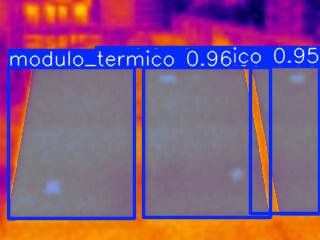

In [ ]:
from ultralytics import YOLO
import os

model = YOLO('runs/segment/train2/weights/best.pt')

image_path = '/content/drive/MyDrive/ISEP-YOLO/termografias_tcc_03/imagens_de_teste/IR_00130.jpg'

# Rodar predição
results = model.predict(
    source=image_path,
    conf=0.8,  # confiança mínima
    save=True  # salva resultado com segmentação sobreposta
)

output_dir = results[0].save_dir
print("Resultado salvo em:", output_dir)

from IPython.display import Image, display

# Mostrar a imagem com segmentação
output_image_path = os.path.join(output_dir, os.path.basename(image_path))
display(Image(filename=output_image_path))

In [ ]:
# Extrair confianças
confidences = results[0].boxes.conf.cpu().numpy()  # array de valores float

# Mostrar os valores
print("Confianças encontradas na imagem:")
for i, conf in enumerate(confidences):
    print(f"Detecção {i+1}: {conf:.2f}")

Confianças encontradas na imagem:
Detecção 1: 0.96
Detecção 2: 0.95
Detecção 3: 0.95


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Carregar imagem original
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Obter a máscara do resultado
masks = results[0].masks

if masks is not None:
    combined_mask = np.any(masks.data.cpu().numpy(), axis=0).astype(np.uint8)
    inverse_mask = 1 - combined_mask

    # Redimensionar imagem original para bater com a máscara
    mask_height, mask_width = inverse_mask.shape
    image_resized = cv2.resize(image, (mask_width, mask_height))

    # Expandir para 3 canais e aplicar máscara
    inverse_mask_3ch = np.stack([inverse_mask]*3, axis=-1)
    masked_image = np.where(inverse_mask_3ch == 1, [255, 255, 255], image_resized)

    # Mostrar
    plt.figure(figsize=(10, 6))
    plt.imshow(masked_image)
    plt.title("")
    plt.axis('off')
    plt.show()
else:
    print("Nenhuma máscara encontrada.")

NameError: name 'image_path' is not defined